<a href="https://colab.research.google.com/github/Moneebah/Finetuning_Real-ESRGAN_Pneumonia/blob/main/FinetuneReal_ESRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FINETUNING REAL-ESRGAN**


> Task by: Software group
>
>> Initial phases of finetuning Real-ESRGAN onto low res and smaller xray image sizes to provide a more accurate output
>
>>Used Kaggle chest xray dataset throughout both finetuning and binary classification.
>>
>>The training dataset for the finetuning task has around 17,000 images after preparation methods that included scaled versions and cropped sub-images of original dataset
>
>> Model was trained for 3,500 iterations (due to GPU constraints)
>
>> Model inference was performed on around 1,700 input images



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# SETUP
entering into the folder where pre-trained model is to be cloned


In [ ]:
%cd /content/drive/MyDrive/NCL-INTERN

/content/drive/MyDrive/NCL-INTERN


clone the Real-ESRGAN respository

In [ ]:
!git clone https://github.com/xinntao/Real-ESRGAN.git

enter the Real-ESRGAN folder, this is where all the work will be done

In [ ]:
%cd Real-ESRGAN


/content/drive/MyDrive/NCL-INTERN/Real-ESRGAN


install all dependencies at the start. there are also python dependencies which are assumed in this colab file

In [ ]:
# Install basicsr - https://github.com/xinntao/BasicSR
# We use BasicSR for both training and inference
!pip install --use-pep517
!pip install basicsr
# facexlib and gfpgan are for face enhancement
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

ERROR: You must give at least one requirement to install (see "pip help install")
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-base

# Dataset preparation
dataset downloaded in Real-ESERGAN folder by creating the following path: dataset/pneumonia and within this will be the training data



> this is the exact dataset used:
>
> [pneumonia dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
>

By the end of it the directory should have two folders NORMAL and PNEUMONIA and the paths look something like this:

>Real-ESRGAN > dataset > pneumonia > NORMAL
>
>Real-ESRGAN > dataset > pneumonia > PNEUMONIA










transferring all data from PNEUMONIA folder to NORMAL folder so that all training data lies in one table

In [ ]:
import os
import shutil

# path here
path = '/content/drive/MyDrive/NCL-INTERN/Real-ESRGAN/dataset/pneumonia'

# source folder
src = f'{path}/PNEUMONIA'

# destination folder
dst = f'{path}/NORMAL'

# list all files in source directory
files = os.listdir(src)

# loop to move all files from source to destination directory
for file_name in files:
    shutil.move(os.path.join(src, file_name), dst)

print("Files moved successfully.")

rename the NORMAL folder to HDtrain


create degraded images using the generate_multiscale_DF2K.py file to first scale the images (set the min to 200)



> changed original repos code to this:
>
>```
    scale_list = [0.5, 1/3, 0.18]
    shortest_edge = 200
```





In [ ]:
!python scripts/generate_multiscale_DF2K.py --input dataset/pneumonia/HDtrain --output dataset/pneumonia/HDmultiscale


dataset/pneumonia/HDtrain/IM-0001-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0003-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0005-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0006-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0007-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0009-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0010-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0011-0001-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0011-0001-0002.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0011-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0013-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0015-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0016-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0017-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0019-0001.jpeg
	0.50
	0.33
	0.18
dataset/pneumonia/HDtrain/IM-0021-0001.jpeg
	0.50
	0.33
	0.1

cropping scaled images into sub images and placing these sub images into a seperate folder

In [ ]:
!python scripts/extract_subimages.py --input dataset/pneumonia/HDmultiscale --output dataset/pneumonia/HDmultiscale_sub --crop_size 400 --step 200


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
mkdir dataset/pneumonia/HDmultiscale_sub ...
Extract:  21% 527/2496 [01:50<06:52,  4.77image/s]
All processes done.


creating meta information for all images (HDtrain, HDmultiscale, HDmultiscale_sub) that will be used in training

In [ ]:
!python scripts/generate_meta_info.py --input dataset/pneumonia/HDtrain dataset/pneumonia/HDmultiscale dataset/pneumonia/HDmultiscale_sub --root dataset/pneumonia dataset/pneumonia dataset/pneumonia --meta_info dataset/pneumonia/meta_info.txt

Streaming output truncated to the last 5000 lines.
HDmultiscale/person81_bacteria_396T2.png
HDmultiscale/person81_bacteria_396T3.png
HDmultiscale/person81_bacteria_397T0.png
HDmultiscale/person81_bacteria_397T1.png
HDmultiscale/person81_bacteria_397T2.png
HDmultiscale/person81_bacteria_397T3.png
HDmultiscale/person81_bacteria_398T0.png
HDmultiscale/person81_bacteria_398T1.png
HDmultiscale/person81_bacteria_398T2.png
HDmultiscale/person81_bacteria_398T3.png
HDmultiscale/person82_bacteria_402T0.png
HDmultiscale/person82_bacteria_402T1.png
HDmultiscale/person82_bacteria_402T2.png
HDmultiscale/person82_bacteria_402T3.png
HDmultiscale/person82_bacteria_403T0.png
HDmultiscale/person82_bacteria_403T1.png
HDmultiscale/person82_bacteria_403T2.png
HDmultiscale/person82_bacteria_403T3.png
HDmultiscale/person82_bacteria_404T0.png
HDmultiscale/person82_bacteria_404T1.png
HDmultiscale/person82_bacteria_404T2.png
HDmultiscale/person82_bacteria_404T3.png
HDmultiscale/person82_bacteria_405T0.png
HDmult

# Download pre-trained models

Download these pre-trained models into experiments/pretrained_models:


>RealESRGAN_x4plus.pth
>
>RealESRGAN_x4plus_netD.pth



In [ ]:
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

In [ ]:
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.2.3/RealESRGAN_x4plus_netD.pth -P experiments/pretrained_models


# Finetuning

modifying the config file (options > finetune_realesrgan_x4plus.yml) according to training time and adjusting checkpoints, paths etc to make sure all point to the correct data.

>dataset settings
>
>```
>datasets:
  train:
    name: pneumonia
    type: RealESRGANDataset
    dataroot_gt: dataset/pneumonia
    meta_info: dataset/pneumonia/meta_info.txt
    io_backend:
      type: disk
```
> loader setting
>
>
>```
 >   # data loader
    use_shuffle: true
    num_worker_per_gpu: 5
    batch_size_per_gpu: 10
    dataset_enlarge_ratio: 1
    prefetch_mode: ~
```
>



In [ ]:
!python realesrgan/train.py -opt options/finetune_realesrgan_x4plus.yml --auto_resume

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
Disable distributed.
2023-09-12 14:13:36,795 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ 

# INFERENCE

Testing the model on input and checking results data

Place data into "input" folder inside the Real-ESRGAN folder

Ouput will be present in the "output" folder in the Real-ESRGAN folder

1. Test the original model

run the code and then check the results folder

In [ ]:
!python inference_realesrgan.py --model_path experiments/pretrained_models/RealESRGAN_x4plus.pth --input inputs


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
Testing 0 blur
Testing 1 slightly blur
Testing 2 slightlysmall
Testing 3 very blur
Testing 4 verysmall


2. Check the finetuned model and compare results!

In [ ]:
!python inference_realesrgan.py --model_path experiments/finetune_pneumonia_RealESRGANx4plus_400k/models/net_g_latest.pth --input inputs


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
Testing 0 blur
Testing 1 slightly blur
Testing 2 slightlysmall
Testing 3 very blur
Testing 4 verysmall


# Results
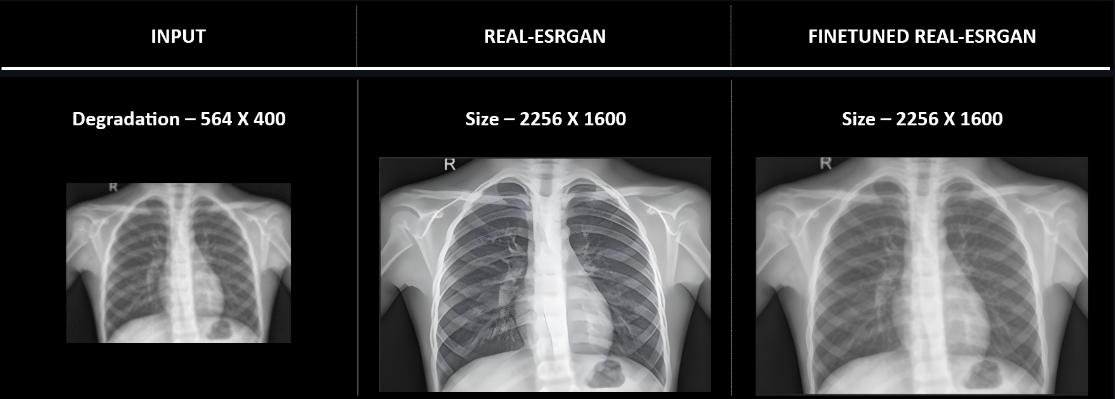

